## **CS410 Project:**
## **Text Classification Competition: Twitter Sarcasm Detection**

**Team Name:** 
*   Team Commonwealth

**Team Members:**
*   Zuliang Weng / zwe
*   Zijing Chen / zijingc3
*   Liping Xie / lipingx2 (captain)





# 1. Setup

## 1.1. Using Colab GPU for Training


Make sure GPU is assigned

In [1]:
import tensorflow as tf
import torch

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
GPU: Tesla T4


## 1.2. Install the Hugging Face Library


In [2]:
!pip install transformers

     |████████████████████████████████| 1.4MB 22.9MB/s 
     |████████████████████████████████| 2.9MB 56.6MB/s 
     |████████████████████████████████| 890kB 52.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=1e768ea5aa08993bd52a22102520f725eb27252b4fcbdfbe02bc2e34bf14c168
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# 2. Prepare train data and test data


## 2.1. Upload files

upload train.jsonl and test.jsonl files here to this instance's file system.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.jsonl to test.jsonl
Saving train.jsonl to train.jsonl
User uploaded file "test.jsonl" with length 1308642 bytes
User uploaded file "train.jsonl" with length 3876480 bytes


## 2.2. Parse

Since train data and test data are in jsonl format, we will need to manually convert them list and then pass into pandas to create a dataframe

In [4]:
import pandas as pd
import json

def load_jsonl(input_path) -> list:
    data = []
    with open(input_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.rstrip('\n|\r').replace('@USER', '')))
    print('Loaded {} records from {}'.format(len(data), input_path))
    return data

train_data = load_jsonl('train.jsonl')
db_data = []
db_cols = ['label', 'response']
for d in train_data:
    db_data.append([])
    for col in db_cols:
        db_data[-1].append(d.get(col, float('nan')))
        
df = pd.DataFrame(db_data, columns=db_cols)

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.loc[df.label == "SARCASM"].sample(5)[['response', 'label']]

Loaded 5000 records from train.jsonl
Number of training sentences: 5,000



,response,label
2215,I guess I should have put at the end of my ...,SARCASM
2022,so BASICALLY the same way we felt for the l...,SARCASM
1944,Yep and you've demonstrated your ignorance by...,SARCASM
1962,terrible practice . How dare you let your kid...,SARCASM
2071,"me neither ! But , i did kinda need a table ....",SARCASM




Change labels to numeric values

In [5]:
sentences = df.response.values
labels = df.label.apply(lambda x: 1 if x == "SARCASM" else 0).values
labels

array([1, 1, 1, ..., 0, 0, 0])

# 3. Tokenization

## 3.1. BERT Tokenizer

There are many different pre-trained BERT models available. Each model comes with its own tokenizer. We need to make sure we used the correct tokenizer as we experient with different models.


In [6]:
from transformers import BertTokenizer
from transformers import pipeline,AutoTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
# test 1
# tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)
# ...

# test 2
# task='irony'
# MODEL = "cardiffnlp/twitter-roberta-base-{task}"
# tokenizer = AutoTokenizer.from_pretrained(MODEL)
# print(MODEL)

# test 3
MODEL = f"cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
print(MODEL)

Loading BERT tokenizer...



cardiffnlp/twitter-roberta-base


Examine the tokens

In [7]:

print('Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:     I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..
Tokenized:  ['Ġ', 'Ġ', 'ĠI', 'Ġdon', "'t", 'Ġget', 'Ġthis', 'Ġ..', 'Ġobviously', 'Ġyou', 'Ġdo', 'Ġcare', 'Ġor', 'Ġyou', 'Ġwould', "'ve", 'Ġmoved', 'Ġright', 'Ġalong', 'Ġ..', 'Ġinstead', 'Ġyou', 'Ġdecided', 'Ġto', 'Ġcare', 'Ġand', 'Ġtroll', 'Ġher', 'Ġ..']
Token IDs:  [1437, 1437, 38, 218, 75, 120, 42, 29942, 3334, 47, 109, 575, 50, 47, 74, 348, 1410, 235, 552, 29942, 1386, 47, 1276, 7, 575, 8, 29989, 69, 29942]


## 3.2. Required Formatting

BERT requires tokens to fit certain format:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".

BERT has two constraints:

1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.


## 3.3. Tokenize Dataset

First, let's find out the max_len in all the sentences

In [8]:
max_len = 0
for sent in sentences:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  106



Tokenize all of the sentences and map the tokens to thier word IDs.

In [9]:
input_ids = []
attention_masks = []

for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,             
        max_length = max_len,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt')
       
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:     I don't get this .. obviously you do care or you would've moved right along .. instead you decided to care and troll her ..
Token IDs: tensor([    0,  1437,  1437,    38,   218,    75,   120,    42, 29942,  3334,
           47,   109,   575,    50,    47,    74,   348,  1410,   235,   552,
        29942,  1386,    47,  1276,     7,   575,     8, 29989,    69, 29942,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1])


## 3.4. Training & Validation Split


split our training data into training set and validation set

In [10]:
from torch.utils.data import TensorDataset, random_split

#train_ratio = 0.8
# train_ratio = 0.9
train_ratio = 0.9

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,500 training samples
  500 validation samples


using a DataLoader will help us save memory

In [11]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size)

print("Done")

Done


# 4. Fine-tune BERT Models

* First we modify the pre-trained BERT model to give outputs for classification.
* Then we continue training the model on our dataset until to improve precision and recall. 

Here is the a list that we have experimented
* BertModel
* twitter-roberta-base (chosen model)
* twitter-roberta-base-irony

## 4.1. Download twitter-roberta-base model

In [12]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification

# Test 1
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
# model = BertForSequenceClassification.from_pretrained(
#     "bert-large-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )
# ...
# Test 3
# Note that MODEL was defined earlier when we choose the tokenizer

print("Using model: " + MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

model.cuda()

Using model: cardiffnlp/twitter-roberta-base


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [13]:
# Examine the model

params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (50265, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           (

## 4.2. Optimizer & Learning Rate Scheduler

For training,

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4


In [14]:
from transformers import get_linear_schedule_with_warmup

# Use AdamW optimizer
optimizer = AdamW(
    model.parameters(),
    lr = 2e-5,
    eps = 1e-8)

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps)

print('Done')

Done


## 4.3. Training Loop

The following training loop is largely based on the contribution of Stas Bekman.

Essentially which loop has a training phase and a validation phase. It also detects over-fitting by using validation loss


Define some helper functions

In [15]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Takes a time in seconds and returns a string hh:mm:ss
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

print("Done")

Done


Finally we are ready to start to fine-tune to model


In [16]:
import random
import numpy as np
import time

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        results = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels)
        loss = results[0]
        logits = results[1]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            results = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels)
            loss = results[0]
            logits = results[1]
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:22.
  Batch    80  of    141.    Elapsed: 0:00:45.
  Batch   120  of    141.    Elapsed: 0:01:08.

  Average training loss: 0.51
  Training epcoh took: 0:01:20

Running Validation...
  Accuracy: 0.80
  Validation Loss: 0.40
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:24.
  Batch    80  of    141.    Elapsed: 0:00:48.
  Batch   120  of    141.    Elapsed: 0:01:12.

  Average training loss: 0.35
  Training epcoh took: 0:01:25

Running Validation...
  Accuracy: 0.81
  Validation Loss: 0.45
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    141.    Elapsed: 0:00:24.
  Batch    80  of    141.    Elapsed: 0:00:48.
  Batch   120  of    141.    Elapsed: 0:01:13.

  Average training loss: 0.24
  Training epcoh took: 0:01:25

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.41
  Validation too

Review the training process

In [17]:
import pandas as pd
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.51,0.40,0.80,0:01:20,0:00:03
2,0.35,0.45,0.81,0:01:25,0:00:03
3,0.24,0.41,0.83,0:01:25,0:00:03
4,0.15,0.46,0.83,0:01:25,0:00:03


Pay special attention to the validation loss. If it starts go increase, we have a over-fitting problem. 
That suggests we should limit the number of epoch.

We can plot a chart to show the trend of training loss and validation loss.


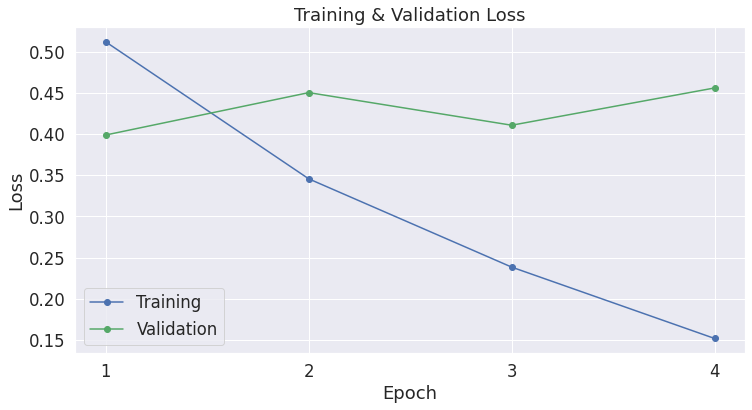

In [18]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Predict on the test data


### 5.1. Data Preparation


Prepare the test data just as how we prepare the training data.

In [19]:
import pandas as pd

test_data = load_jsonl('test.jsonl')
db_data = []
db_cols = ['id', 'response']
for d in test_data:
    db_data.append([])
    for col in db_cols:
        db_data[-1].append(d.get(col, float('nan')))
        
df2 = pd.DataFrame(db_data, columns=db_cols)
df2['label'] = 1
print('Number of test sentences: {:,}\n'.format(df2.shape[0]))

df2.sample(5)

sentences = df2.response.values
labels = df2.label.values

input_ids = []
attention_masks = []

for sentence in sentences:
    encoded_dict = tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,
        max_length = max_len,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt')
      
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data) # note that we use sequential sampler because we are not splitting the data set.
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

print('Done')

Loaded 1800 records from test.jsonl
Number of test sentences: 1,800



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Done


## 5.2. Predict on the test set

In [20]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
model.eval()
predictions = []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(
          b_input_ids, 
          token_type_ids=None, 
          attention_mask=b_input_mask)
  # note that outputs won't have loss in evaluation mode
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)

print('Done')

Predicting labels for 1,800 test sentences...
Done


Generate the final prediction based on the score, and download the result as answer.txt

In [21]:
from google.colab import files

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

df2['pred'] = flat_predictions
df2['result'] = df2.pred.apply(lambda x: "SARCASM" if x == 1 else "NOT_SARCASM")
df2[['id', 'result']].to_csv("answer.txt", header=False, index=False)


files.download('answer.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All the testing results are detailed in the Project Details document.


# Conclusion

BERT is a powerful tool when it comes to classification problem. We are able to create a reasonaly useful model to detect sarcasm in tweets without using a lot of resource for training the models from scratch. 

**References**
* https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109
* https://mccormickml.com/
* https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py
* https://github.com/stas00?tab=repositories